In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import math
from numpy import linalg as la
from scipy.stats import multivariate_normal

## a) Please see writeup for explanations

## b) Parse and Plot

In [2]:
data = pd.read_csv('faithful.dat.txt', skiprows=20, delim_whitespace=True)
data

,eruptions,waiting
1,3.600,79
2,1.800,54
3,3.333,74
4,2.283,62
5,4.533,85
6,2.883,55
7,4.700,88
8,3.600,85
9,1.950,51
10,4.350,85


In [3]:
eruptions = np.array(data['eruptions'])
waiting = np.array(data['waiting'])

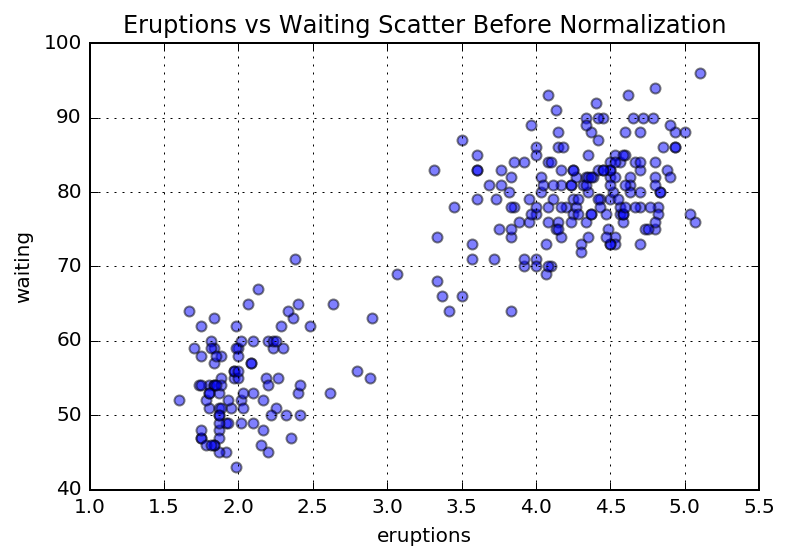

In [4]:
#plot the scatter before normalization
#https://gist.github.com/minrk/3301035
%config InlineBackend.figure_format = 'retina'
plt.scatter(eruptions, waiting, s=25, alpha=0.5, marker='o')
plt.title('Eruptions vs Waiting Scatter Before Normalization')
plt.xlabel('eruptions')
plt.ylabel('waiting')
plt.grid(True)
plt.show()

In [5]:
eruptions_norm = []
waiting_norm = []

In [6]:
#normalize eruptions data
for i in range(len(eruptions)):
    eruptions_norm.append((eruptions[i] - np.amin(eruptions))/(np.amax(eruptions) - np.amin(eruptions)))

In [7]:
#normalize waiting data
for i in range(len(waiting)):
    waiting_norm.append((waiting[i] - np.amin(waiting))/(np.amax(waiting) - np.amin(waiting)))

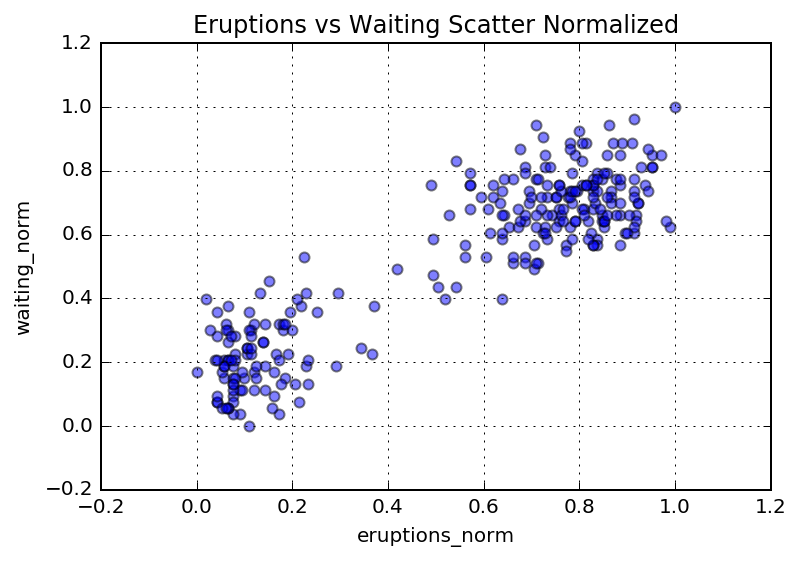

In [8]:
#plot the scatter after normalization
#https://gist.github.com/minrk/3301035
%config InlineBackend.figure_format = 'retina'
plt.scatter(eruptions_norm, waiting_norm, s=25, alpha=0.5, marker='o')
plt.title('Eruptions vs Waiting Scatter Normalized')
plt.xlabel('eruptions_norm')
plt.ylabel('waiting_norm')
plt.grid(True)
plt.show()

## c) Implement GMM model and EM algorithm

In [9]:
eruptions_norm = np.array(eruptions_norm)
waiting_norm = np.array(waiting_norm)

In [10]:
data_norm = np.vstack((eruptions_norm, waiting_norm)).T

In [11]:
#http://mccormickml.com/2014/08/04/gaussian-mixture-models-tutorial-and-matlab-code/
def GMM_EM(data):
    # Initialize mu and sigma
    mu = data[np.random.choice(range(len(data)), 2, replace=False)];
    
    mu1 = mu[0];
    mu2 = mu[1];
    
    sigma0 = np.mean(np.cov(data.T));
    sigma1 = sigma0 * np.identity(2);
    sigma2 = sigma0 * np.identity(2);

    pi1 = 0.5;
    pi2 = 1 - pi1;
    
    # Start EM
    iteration = 0
    traj_eruption_1 = []
    traj_eruption_2 = []
    traj_waiting_1= []
    traj_waiting_2= []
    
    while True:
        oldMu1 = mu1
        oldMu2 = mu2
        
        traj_eruption_1.append(mu1[0])
        traj_waiting_1.append(mu1[1]) 
        traj_eruption_2.append(mu2[0])
        traj_waiting_2.append(mu2[1])
        
        #E-step: get PDFs
        pdf1 = np.zeros(len(data));
        pdf2 = np.zeros(len(data));
        for j in range(len(data)):
            pdf1[j] = multivariate_normal.pdf(data[j], mean=mu1, cov=sigma1);
            pdf2[j] = multivariate_normal.pdf(data[j], mean=mu2, cov=sigma2);
        
        #E-step: get Gammas
        gamma1 = (pi1 * pdf1) / (pi1 * pdf1 + pi2 * pdf2);
        gamma2 = (pi2 * pdf2) / (pi1 * pdf1 + pi2 * pdf2);
        
        #M-step: Update Mus
        mu1 = np.dot(gamma1, data) / np.sum(gamma1);
        mu2 = np.dot(gamma2, data) / np.sum(gamma2); 
        
        #M-step: Update Sigmas
        tempSigma_1 = [];
        tempSigma_2 = [];
        for i in range(len(data)):
            tempSigma_1.append(np.dot(gamma1[i] * (data[i] - mu1).reshape(-1, 1), (data[i] - mu1).reshape(-1, 1).T) / np.sum(gamma1));
            tempSigma_2.append(np.dot(gamma2[i] * (data[i] - mu2).reshape(-1, 1), (data[i] - mu2).reshape(-1, 1).T) / np.sum(gamma2));
        
        sigSum1 = np.sum(tempSigma_1, axis=0) 
        sigSum2 = np.sum(tempSigma_2, axis=0)
        sigma1 = np.mean(sigSum1) * np.identity(2);
        sigma2 = np.mean(sigSum2) * np.identity(2);
        
        #Update Pis
        pi1 = np.sum(gamma1) / len(data);
        pi2 = 1 - pi1;

        if np.allclose(mu1, oldMu1) and np.allclose(mu2, oldMu2):
            print('Now converged')
            break
        else:
            iteration = iteration + 1;
        
        print (traj_eruption_2)
        print (traj_waiting_2)
    
    return iteration, traj_eruption_1, traj_waiting_1, traj_eruption_2, traj_waiting_2

In [12]:
iterNum, traj_x_1, traj_y_1, traj_x_2, traj_y_2 = GMM_EM(data_norm)

[0.84771428571428586]
[0.660377358490566]
[0.84771428571428586, 0.64128370192585804]
[0.660377358490566, 0.60621599715063645]
[0.84771428571428586, 0.64128370192585804, 0.73367498088390848]
[0.660377358490566, 0.60621599715063645, 0.67385837731758003]
[0.84771428571428586, 0.64128370192585804, 0.73367498088390848, 0.78177425383682964]
[0.660377358490566, 0.60621599715063645, 0.67385837731758003, 0.70808515587100684]
[0.84771428571428586, 0.64128370192585804, 0.73367498088390848, 0.78177425383682964, 0.78660222279100389]
[0.660377358490566, 0.60621599715063645, 0.67385837731758003, 0.70808515587100684, 0.71173585155585795]
[0.84771428571428586, 0.64128370192585804, 0.73367498088390848, 0.78177425383682964, 0.78660222279100389, 0.78019924811561037]
[0.660377358490566, 0.60621599715063645, 0.67385837731758003, 0.70808515587100684, 0.71173585155585795, 0.70837826716090813]
[0.84771428571428586, 0.64128370192585804, 0.73367498088390848, 0.78177425383682964, 0.78660222279100389, 0.7801992481

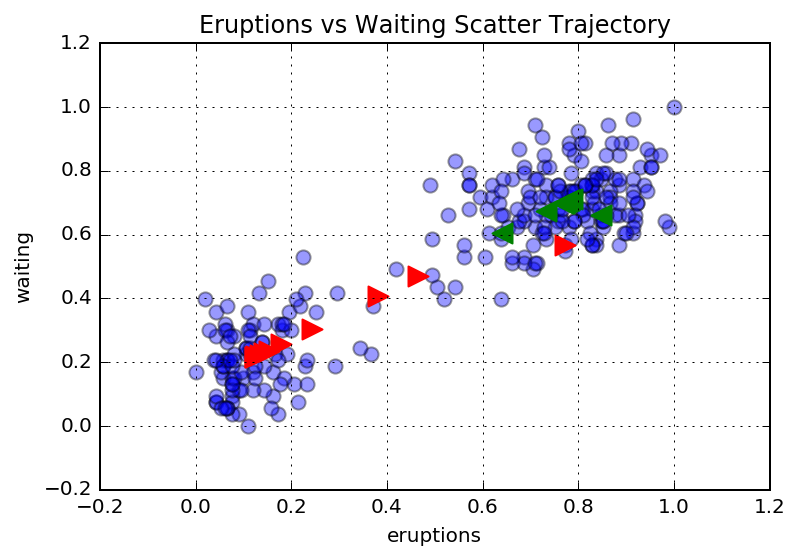

In [13]:
%config InlineBackend.figure_format = 'retina'
plt.scatter(eruptions_norm, waiting_norm, s=50, alpha=0.4, marker='o')
plt.scatter(traj_x_1, traj_y_1, s=100, color = 'red', marker='>')
plt.scatter(traj_x_2, traj_y_2, s=100, color = 'green', marker='<')
plt.title('Eruptions vs Waiting Scatter Trajectory')
plt.xlabel('eruptions')
plt.ylabel('waiting')
plt.grid(True)
plt.show()

In [14]:
iterNum

10

In [15]:
totalIter = []
for i in range(50):
    totalIter.append(GMM_EM(data_norm)[0]);

[0.22857142857142854]
[0.18867924528301888]
[0.22857142857142854, 0.18113419899267136]
[0.18867924528301888, 0.25554043533192156]
[0.22857142857142854, 0.18113419899267136, 0.14644458716712436]
[0.18867924528301888, 0.25554043533192156, 0.2300314590409156]
[0.22857142857142854, 0.18113419899267136, 0.14644458716712436, 0.13738617861938193]
[0.18867924528301888, 0.25554043533192156, 0.2300314590409156, 0.22464278807987473]
[0.22857142857142854, 0.18113419899267136, 0.14644458716712436, 0.13738617861938193, 0.12927632021215874]
[0.18867924528301888, 0.25554043533192156, 0.2300314590409156, 0.22464278807987473, 0.21996004278480283]
[0.22857142857142854, 0.18113419899267136, 0.14644458716712436, 0.13738617861938193, 0.12927632021215874, 0.12544983141250513]
[0.18867924528301888, 0.25554043533192156, 0.2300314590409156, 0.22464278807987473, 0.21996004278480283, 0.21711952869588053]
[0.22857142857142854, 0.18113419899267136, 0.14644458716712436, 0.13738617861938193, 0.12927632021215874, 0.12

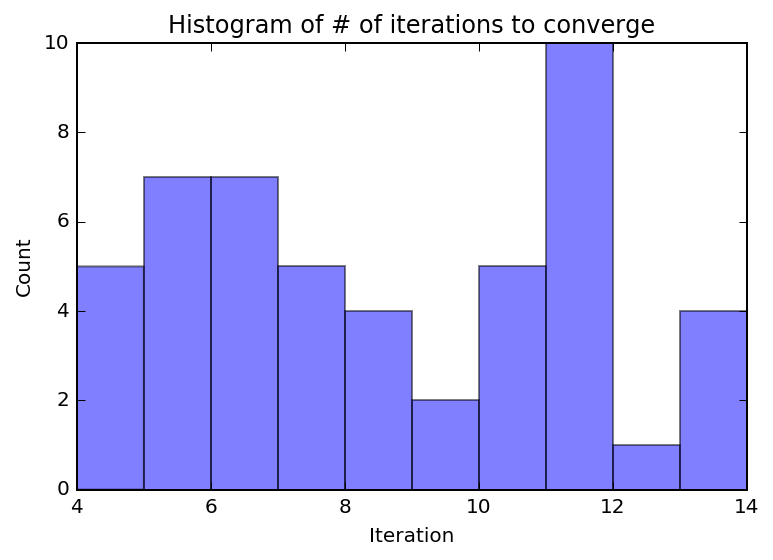

In [16]:
%config InlineBackend.figure_format = 'retina'
plt.hist(totalIter, alpha=0.5)
plt.title('Histogram of # of iterations to converge')
plt.xlabel('Iteration')
plt.ylabel('Count')
plt.show()

## d)

## Run a K-means algorithm over all the data points with K = 2 and label each point with one of the two clusters.

## Estimate the first guess of the mean and covariance matrices using maximum likelihood over the labeled data points.

## Compare the algorithm performances of (c) and (d).

In [17]:
#http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2).fit(data_norm)

In [18]:
kmeans_mu1 = kmeans.cluster_centers_[0]
kmeans_mu2 = kmeans.cluster_centers_[1]

In [19]:
label_0 = data_norm[np.where(kmeans.labels_==0)]
label_1 = data_norm[np.where(kmeans.labels_==1)]

In [20]:
print('Label of each point:', kmeans.labels_)

Label of each point: [1 0 1 0 1 0 1 1 0 1 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0
 1 0 1 1 0 1 0 1 1 1 0 1 0 1 1 0 1 0 1 1 0 1 1 0 1 0 1 0 1 1 1 0 1 1 0 1 1
 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 0 1 0 1 1 1
 0 1 1 0 1 0 1 0 1 0 1 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1 0
 1 0 1 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0
 1 1 0 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1
 0 1 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0
 1 1 1 0 1 0 0 1 1 0 1 0 1]


In [21]:
def Kmeans2GMM(data):
    # Initialize mu and sigma
    kmeans = KMeans(n_clusters=2).fit(data)
    mu1 = kmeans_mu1;
    mu2 = kmeans_mu2;
    
    label_0 = data_norm[np.where(kmeans.labels_==0)]
    label_1 = data_norm[np.where(kmeans.labels_==1)]
    
    t1 = np.mean(np.cov(label_0.T));
    t2 = np.mean(np.cov(label_1.T));
    sigma1 = t1 * np.identity(2);
    sigma2 = t2 * np.identity(2);
    
    pi1 = 0.5;
    pi2 = 1 - pi1;
    
    # Start EM
    iteration = 0
    traj_eruption_1 = []
    traj_eruption_2 = []
    traj_waiting_1= []
    traj_waiting_2= []
    
    while True:
        oldMu1 = mu1
        oldMu2 = mu2
        
        traj_eruption_1.append(mu1[0])
        traj_waiting_1.append(mu1[1]) 
        traj_eruption_2.append(mu2[0])
        traj_waiting_2.append(mu2[1])
        
        #E-step: get PDFs
        pdf1 = np.zeros(len(data));
        pdf2 = np.zeros(len(data));
        for j in range(len(data)):
            pdf1[j] = multivariate_normal.pdf(data[j], mean=mu1, cov=sigma1);
            pdf2[j] = multivariate_normal.pdf(data[j], mean=mu2, cov=sigma2);
        
        #E-step: get Gammas
        gamma1 = (pi1 * pdf1) / (pi1 * pdf1 + pi2 * pdf2);
        gamma2 = (pi2 * pdf2) / (pi1 * pdf1 + pi2 * pdf2);
        
        #M-step: Update Mus
        mu1 = np.dot(gamma1, data) / np.sum(gamma1);
        mu2 = np.dot(gamma2, data) / np.sum(gamma2);
        
        #M-step: Update Sigmas
        tempSigma_1 = [];
        tempSigma_2 = [];
        for i in range(len(data)):
            tempSigma_1.append(np.dot(gamma1[i] * (data[i] - mu1).reshape(-1, 1), (data[i] - mu1).reshape(-1, 1).T) / np.sum(gamma1));
            tempSigma_2.append(np.dot(gamma2[i] * (data[i] - mu2).reshape(-1, 1), (data[i] - mu2).reshape(-1, 1).T) / np.sum(gamma2));
        
        sigSum1 = np.sum(tempSigma_1, axis=0) 
        sigSum2 = np.sum(tempSigma_2, axis=0)
        sigma1 = np.mean(sigSum1) * np.identity(2);
        sigma2 = np.mean(sigSum2) * np.identity(2);
        
        #Update Pis
        pi1 = np.sum(gamma1) / len(data);
        pi2 = 1 - pi1;
        
        if np.allclose(mu1, oldMu1) and np.allclose(mu2, oldMu2):
            print('Now converged')
            break
        else:
            iteration = iteration + 1;
    
    return iteration, traj_eruption_1, traj_waiting_1, traj_eruption_2, traj_waiting_2

In [22]:
iterK, traj_x_1_K, traj_y_1_K, traj_x_2_K, traj_y_2_K = Kmeans2GMM(data_norm)

Now converged


In [23]:
totalIter_K = []
for i in range(50):
    totalIter_K.append(Kmeans2GMM(data_norm)[0]);

Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged
Now converged


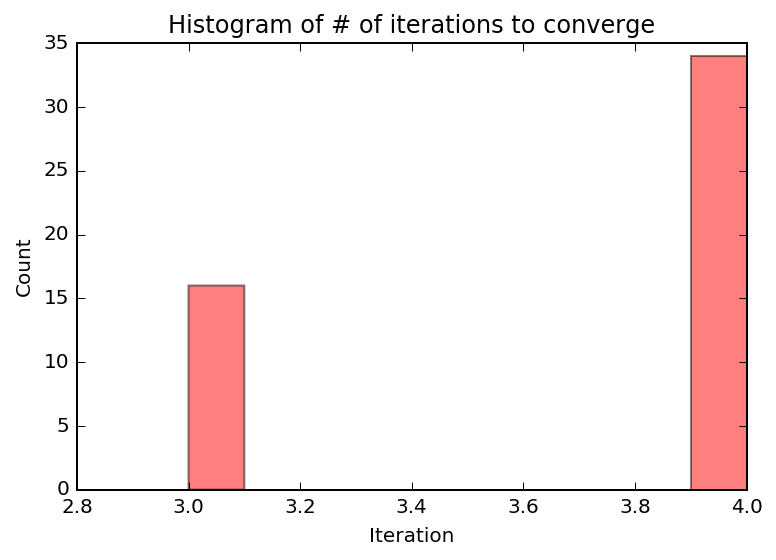

In [24]:
%config InlineBackend.figure_format = 'retina'
plt.hist(totalIter_K, alpha=0.5, color = 'red')
plt.title('Histogram of # of iterations to converge')
plt.xlabel('Iteration')
plt.ylabel('Count')
plt.show()